In [1]:
%reset
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R_sci

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
#paramaters
t = symbols("t")

m = 0.5802999999999999
g = -9.81
l = 0.108354242996334

G = Matrix([0,0,g])



MI = Matrix([[0.000778741496230108,                    0,                   0], 
             [                   0, 0.000759452121539762,                   0], 
             [                   0,                    0, 0.00153725292232051]]) #Rounded to diagonal

In [3]:
#Interial Frame Vectors
x = Function('x')(t)
y = Function('y')(t)
z = Function('z')(t)

xd     = diff(x,t)
yd     = diff(y,t)
zd     = diff(z,t)

xdd    = diff(x,(t,2))
ydd    = diff(y,(t,2))
zdd    = diff(z,(t,2))

X_i    = Matrix([x,y,z])
Xd_i   = Matrix([xd, yd, zd])
Xdd_i  = Matrix([xdd, ydd, zdd])


In [4]:
#Rotation Setup
#Euler
phi    = Function('phi')(t)
theta  = Function('theta')(t)
psi    = Function('psi')(t)

T_i    = Matrix([phi, theta, psi])

#Quaternians
q0     = Function('q0')(t)
q1     = Function('q1')(t)
q2     = Function('q2')(t)
q3     = Function('q3')(t)

q = Matrix([q0,q1,q2,q3])

phi   = atan2(2*(q0*q1 + q2*q3), q0**2 - q1**2 - q2**2 + q3**2)
theta = asin(2*(q0*q2 - q3*q1))
psi   = atan2(2*(q0*q3 + q2*q1), q0**2 + q1**2 - q2**2 - q3**2)

wx    = Function('wx')(t)
wy    = Function('wy')(t)
wz    = Function('wz')(t)

wxd   = diff(wx,t)
wyd   = diff(wy,t)
wzd   = diff(wz,t)

w     = Matrix([wx,wy,wz])

wd    = Matrix([wxd,wyd,wzd])

p    = Matrix([0,wx,wy,wz])

Q     = Matrix([[q0,-q1,-q2,-q3],
                [q1, q0, q3,-q2],
                [q2,-q3, q0, q1],
                [q3, q2,-q1, q0]])

qd = (-1/2) * Matrix([p[0]*q0 - p[1]*q1 - p[2]*q2 - p[3]*q3,
                      p[0]*q1 + p[1]*q0 + p[2]*q3 - p[3]*q2,
                      p[0]*q2 - p[1]*q3 + p[2]*q0 + p[3]*q1,
                      p[0]*q3 + p[1]*q2 - p[2]*q1 + p[3]*q0])

In [5]:
#Rotation Matrix
R = Matrix([[1-2*q2**2-2*q3**2      ,         2*q1*q2-2*q0*q3,         2*q1*q3+2*q0*q2],
            [        2*q1*q2+2*q0*q3, 1-2*q1**2-2*q3**2      ,         2*q2*q3-2*q0*q1],
            [        2*q1*q3-2*q0*q2,         2*q2*q3+2*q0*q1, 1-2*q1**2-2*q2**2      ]])
R

Matrix([
[  -2*q2(t)**2 - 2*q3(t)**2 + 1, -2*q0(t)*q3(t) + 2*q1(t)*q2(t),  2*q0(t)*q2(t) + 2*q1(t)*q3(t)],
[ 2*q0(t)*q3(t) + 2*q1(t)*q2(t),   -2*q1(t)**2 - 2*q3(t)**2 + 1, -2*q0(t)*q1(t) + 2*q2(t)*q3(t)],
[-2*q0(t)*q2(t) + 2*q1(t)*q3(t),  2*q0(t)*q1(t) + 2*q2(t)*q3(t),   -2*q1(t)**2 - 2*q2(t)**2 + 1]])

In [6]:
#Newton & Quaternians

F1, F2, F3, F4 = symbols("F1, F2, F3, F4")
T1, T2, T3, T4 = symbols("T1, T2, T3, T4")

F1_rotor = Matrix([0,0,F1]) 
F2_rotor = Matrix([0,0,F2])
F3_rotor = Matrix([0,0,F3])
F4_rotor = Matrix([0,0,F4])

T1_rotor = Matrix([0,0,T1])
T2_rotor = Matrix([0,0,T2])
T3_rotor = Matrix([0,0,T3])
T4_rotor = Matrix([0,0,T4])

R1_rotor = Matrix([l,0,0])
R2_rotor = Matrix([0,l,0])
R3_rotor = Matrix([-l,0,0])
R4_rotor = Matrix([0,-l,0])

In [7]:
XDD = ((m*G + R @ F1_rotor + R @ F2_rotor + R @ F3_rotor + R @ F4_rotor)/m)

In [8]:
Torque =  (T1_rotor + T2_rotor + T3_rotor + T4_rotor + R1_rotor.cross(F1_rotor) + R2_rotor.cross(F2_rotor) + R3_rotor.cross(F3_rotor) + R4_rotor.cross(F4_rotor)) 
wd = MI.inv() @ Torque - MI.inv() @ (w.cross(MI @ w))

In [9]:
XDD[0].simplify()

3.44649319317594*(q0(t)*q2(t) + q1(t)*q3(t))*(F1 + F2 + F3 + F4)

In [10]:
XDD[1].simplify()

3.44649319317594*(q0(t)*q1(t) - q2(t)*q3(t))*(-F1 - F2 - F3 - F4)

In [11]:
XDD[2].simplify()

-1.72324659658797*F1*(2*q1(t)**2 + 2*q2(t)**2 - 1) - 1.72324659658797*F2*(2*q1(t)**2 + 2*q2(t)**2 - 1) - 1.72324659658797*F3*(2*q1(t)**2 + 2*q2(t)**2 - 1) - 1.72324659658797*F4*(2*q1(t)**2 + 2*q2(t)**2 - 1) - 9.81

In [12]:
wd[0]

139.140194173391*F2 - 139.140194173391*F4 - 0.998792031176053*wy(t)*wz(t)

In [13]:
wd[1]

-142.674225172549*F1 + 142.674225172549*F3 + 0.998761349895958*wx(t)*wz(t)

In [14]:
wd[2]

650.511041794269*T1 + 650.511041794269*T2 + 650.511041794269*T3 + 650.511041794269*T4 + 0.012547951225377*wx(t)*wy(t)

In [15]:
#Motor Functions
kv      = 1750 #rpm/v from motor
V       = 22.2 #v from battery
Amax    = 55   #from ESC
kt      = ((kv*2*np.pi)/60) #https://www.tytorobotics.com/blogs/articles/how-to-calculate-electric-motor-torque

C       = (kv*V*2*np.pi)/60 # max rad/s
Tmax    = kt*Amax
B       = C/Tmax

Ct      = 1       #Thrust coeffecient need to find
rho     = 1.293   #kg/m3 atmo density
D       = 0.12954 #m for 5.1 inch rotors
def Fmotor(T):
    rads   = -B*T + C
    thrust = Ct * rho * (rads/(2*np.pi))**2 * D**4
    return thrust


In [16]:
#Torque & Intial Conditions configuration For 1 Minute Circle with 10 ms accuracy 
dt        = 0.01  #s
T_max     = 60   #s

ic_x      = 4     #m
ic_xd     = 0.5     #m/s

ic_y      = 2     #m
ic_yd     = 0     #m/s

ic_z      = 1     #m
ic_zd     = 0     #m/s

ic_q0     = 0.999979707126395     #rad

ic_q1     = -0.00637066208567390     #rad

ic_q2     = 0     #rad

ic_q3     = 0     #rad

ic_wx     = 0     #rad/s 

ic_wy     = 0     #rad/s 

ic_wz     = -0.25     #rad/s 

t1 =  9106.011767024882  #ccw
t2 = -9106.011767024882 #cw
t3 =  9106.011767024882  #ccw
t4 = -9106.011767024882 #cw

f1 = Fmotor(t1)
f2 = Fmotor(-t2)
f3 = Fmotor(t3)
f4 = Fmotor(-t4)

In [17]:
#Simply Propagator

T         = np.array([0])

x_t       = np.array([ic_x])
xd_t      = np.array([ic_xd])

y_t       = np.array([ic_y])
yd_t      = np.array([ic_yd])

z_t       = np.array([ic_z])
zd_t      = np.array([ic_zd])

xdd_t     = np.array(  [XDD[0].subs(q0,ic_q0).subs(q1,ic_q1).subs(q2,ic_q2).subs(q3,ic_q3).subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4)])
ydd_t     = np.array(  [XDD[1].subs(q0,ic_q0).subs(q1,ic_q1).subs(q2,ic_q2).subs(q3,ic_q3).subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4)])
zdd_t     = np.array(  [XDD[2].subs(q0,ic_q0).subs(q1,ic_q1).subs(q2,ic_q2).subs(q3,ic_q3).subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4)])

q0_t      = np.array([ic_q0])

q1_t      = np.array([ic_q1])

q2_t      = np.array([ic_q2])

q3_t      = np.array([ic_q3])

wx_t      = np.array([ic_wx])

wy_t      = np.array([ic_wy])

wz_t      = np.array([ic_wz])

q0d_t      = np.array([-0.5*(-ic_wx*ic_q1 - ic_wy*ic_q2 - ic_wz*ic_q3)])

q1d_t      = np.array([-0.5*( ic_wx*ic_q0 + ic_wy*ic_q3 - ic_wz*ic_q2)])

q2d_t      = np.array([-0.5*(-ic_wx*ic_q3 + ic_wy*ic_q0 + ic_wz*ic_q1)])

q3d_t      = np.array([ -0.5*(ic_wx*ic_q2 - ic_wy*ic_q1 + ic_wz*ic_q0)])

wxd_t     = np.array(  [wd[0].subs(q0,ic_q0).subs(q1,ic_q1).subs(q2,ic_q2).subs(q3,ic_q3).subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4).subs(T1,t1).subs(T2,t2).subs(T3,t3).subs(T4,t4).subs(wx,ic_wx).subs(wy,ic_wy).subs(wz,ic_wz)])
wyd_t     = np.array(  [wd[1].subs(q0,ic_q0).subs(q1,ic_q1).subs(q2,ic_q2).subs(q3,ic_q3).subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4).subs(T1,t1).subs(T2,t2).subs(T3,t3).subs(T4,t4).subs(wx,ic_wx).subs(wy,ic_wy).subs(wz,ic_wz)])
wzd_t     = np.array(  [wd[2].subs(q0,ic_q0).subs(q1,ic_q1).subs(q2,ic_q2).subs(q3,ic_q3).subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4).subs(T1,t1).subs(T2,t2).subs(T3,t3).subs(T4,t4).subs(wx,ic_wx).subs(wy,ic_wy).subs(wz,ic_wz)])

p = 0

while (T[p] < T_max):
    xd_t     = np.append(xd_t,      xd_t[p]     + xdd_t[p]     * dt)
    x_t      = np.append(x_t,       x_t[p]      + xd_t[p]      * dt) 
    yd_t     = np.append(yd_t,      yd_t[p]     + ydd_t[p]     * dt)
    y_t      = np.append(y_t,       y_t[p]      + yd_t[p]      * dt)
    zd_t     = np.append(zd_t,      zd_t[p]     + zdd_t[p]     * dt)
    z_t      = np.append(z_t,       z_t[p]      + zd_t[p]      * dt)
    
    wx_t     = np.append(wx_t,      wx_t[p]      + wxd_t[p]    * dt)
    wy_t     = np.append(wy_t,      wy_t[p]      + wyd_t[p]    * dt)
    wz_t     = np.append(wz_t,      wz_t[p]      + wzd_t[p]    * dt)
    
    q0d_t    = np.append(q0d_t,   -0.5*(-wx_t[p]*q1_t[p] - wy_t[p]*q2_t[p] - wz_t[p]*q3_t[p])) 
    q1d_t    = np.append(q1d_t,   -0.5*( wx_t[p]*q0_t[p] + wy_t[p]*q3_t[p] - wz_t[p]*q2_t[p])) 
    q2d_t    = np.append(q2d_t,   -0.5*(-wx_t[p]*q3_t[p] + wy_t[p]*q0_t[p] + wz_t[p]*q1_t[p]))
    q3d_t    = np.append(q3d_t,   -0.5*( wx_t[p]*q2_t[p] - wy_t[p]*q1_t[p] + wz_t[p]*q0_t[p]))
    
    q0_t     = np.append(q0_t,     q0_t[p]      + q0d_t[p]     * dt) 
    q1_t     = np.append(q1_t,     q1_t[p]      + q1d_t[p]     * dt) 
    q2_t     = np.append(q2_t,     q2_t[p]      + q2d_t[p]     * dt) 
    q3_t     = np.append(q3_t,     q3_t[p]      + q3d_t[p]     * dt) 
    
    xdd_t    = np.append(xdd_t,     XDD[0].subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4).subs(q0,q0_t[p+1]).subs(q1,q1_t[p+1]).subs(q2,q2_t[p+1]).subs(q3,q3_t[p+1]))
    ydd_t    = np.append(ydd_t,     XDD[1].subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4).subs(q0,q0_t[p+1]).subs(q1,q1_t[p+1]).subs(q2,q2_t[p+1]).subs(q3,q3_t[p+1]))
    zdd_t    = np.append(zdd_t,     XDD[2].subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4).subs(q0,q0_t[p+1]).subs(q1,q1_t[p+1]).subs(q2,q2_t[p+1]).subs(q3,q3_t[p+1]))
    
    wxd_t    = np.append(wxd_t,    wd[0].subs(q0,q0_t[p+1]).subs(q1,q1_t[p+1]).subs(q2,q2_t[p+1]).subs(q3,q3_t[p+1]).subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4).subs(T1,t1).subs(T2,t2).subs(T3,t3).subs(T4,t4).subs(wx,wx_t[p+1]).subs(wy,wy_t[p+1]).subs(wz,wz_t[p+1]))
    wyd_t    = np.append(wyd_t,    wd[1].subs(q0,q0_t[p+1]).subs(q1,q1_t[p+1]).subs(q2,q2_t[p+1]).subs(q3,q3_t[p+1]).subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4).subs(T1,t1).subs(T2,t2).subs(T3,t3).subs(T4,t4).subs(wx,wx_t[p+1]).subs(wy,wy_t[p+1]).subs(wz,wz_t[p+1]))
    wzd_t    = np.append(wzd_t,    wd[2].subs(q0,q0_t[p+1]).subs(q1,q1_t[p+1]).subs(q2,q2_t[p+1]).subs(q3,q3_t[p+1]).subs(F1,f1).subs(F2,f2).subs(F3,f3).subs(F4,f4).subs(T1,t1).subs(T2,t2).subs(T3,t3).subs(T4,t4).subs(wx,wx_t[p+1]).subs(wy,wy_t[p+1]).subs(wz,wz_t[p+1]))
    
    T = np.append(T,T[p] + dt)
    
    if p % 100 == 0:
        print(p)
 
    p = p + 1 
    
print(T)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
[0.000e+00 1.000e-02 2.000e-02 ... 5.999e+01 6.000e+01 6.001e+01]


In [18]:
#quaternians to euler
phi_t   = np.array([])
theta_t = np.array([])
psi_t   = np.array([])

for i in range(len(q0_t)):
    phi_t = np.append(phi_t, phi.subs(q0,q0_t[i]).subs(q1,q1_t[i]).subs(q2,q2_t[i]).subs(q3,q3_t[i]))
    theta_t = np.append(theta_t, theta.subs(q0,q0_t[i]).subs(q1,q1_t[i]).subs(q2,q2_t[i]).subs(q3,q3_t[i]))
    psi_t = np.append(psi_t, psi.subs(q0,q0_t[i]).subs(q1,q1_t[i]).subs(q2,q2_t[i]).subs(q3,q3_t[i]))
    if i % 100 == 0:
        print(i)
for i in range(len(phi_t)):
    if phi_t[i] == nan:
        phi_t[i] = 0
    if theta_t[i] == nan:
        theta_t[i] = 0
    if psi_t[i] == nan:
        psi_t[i] = 0

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


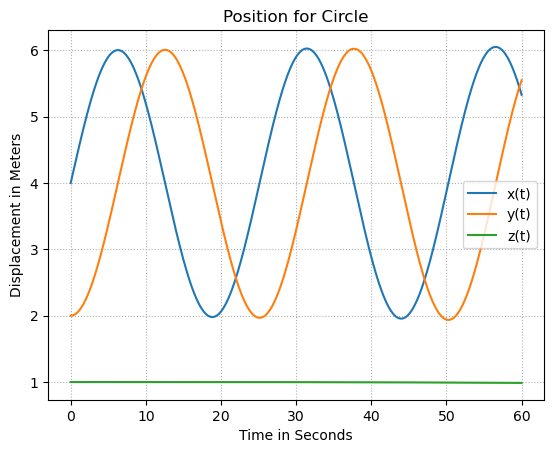

In [19]:

plt.plot(T, x_t, label='x(t)')  
plt.plot(T, y_t, label='y(t)')
plt.plot(T, z_t, label='z(t)')

plt.xlabel('Time in Seconds')
plt.ylabel('Displacement in Meters')
plt.title('Position for Circle')
plt.grid(True, linestyle =':')


plt.legend()

plt.show()


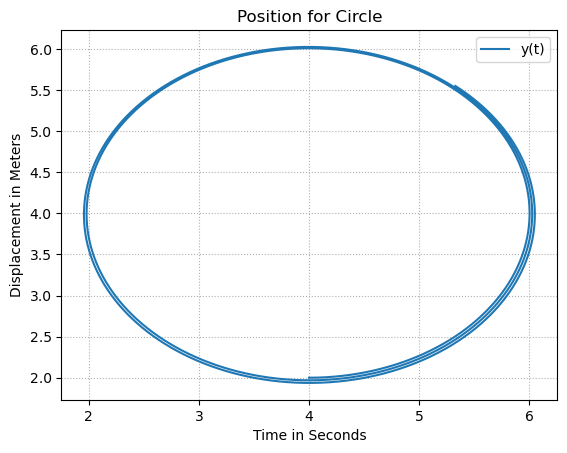

In [20]:
  
plt.plot(x_t, y_t, label='y(t)')


plt.xlabel('Time in Seconds')
plt.ylabel('Displacement in Meters')
plt.title('Position for Circle')
plt.grid(True, linestyle =':')


plt.legend()

plt.show()

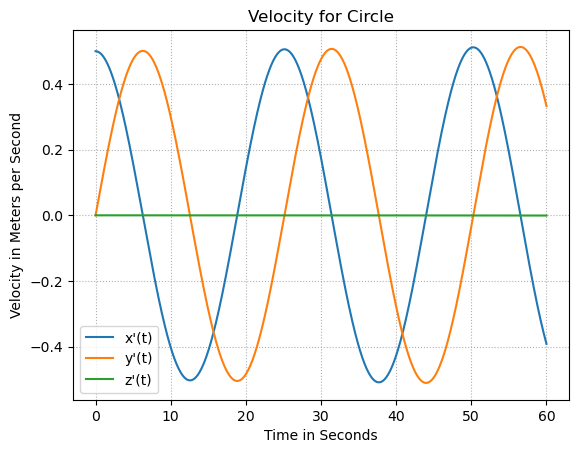

In [21]:
plt.plot(T, xd_t, label='x\'(t)')  
plt.plot(T, yd_t, label='y\'(t)')
plt.plot(T, zd_t, label='z\'(t)')


plt.xlabel('Time in Seconds')
plt.ylabel('Velocity in Meters per Second')
plt.title('Velocity for Circle')
plt.grid(True, linestyle =':')

plt.legend()

plt.show()

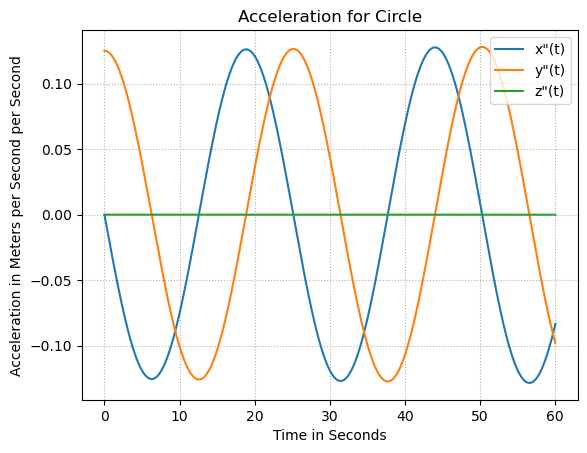

In [22]:
plt.plot(T, xdd_t, label='x\"(t)')  
plt.plot(T, ydd_t, label='y\"(t)')
plt.plot(T, zdd_t, label='z\"(t)')

plt.xlabel('Time in Seconds')
plt.ylabel('Acceleration in Meters per Second per Second')
plt.title('Acceleration for Circle')

plt.grid(True, linestyle =':')

plt.legend()

plt.show()

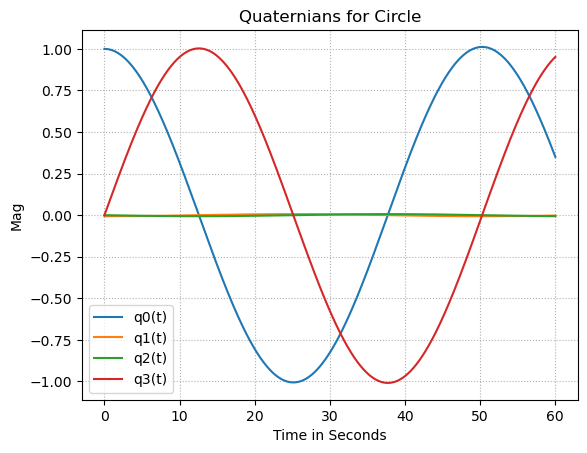

In [23]:
plt.plot(T, q0_t, label='q0(t)')
plt.plot(T, q1_t, label='q1(t)')
plt.plot(T, q2_t, label='q2(t)')
plt.plot(T, q3_t, label='q3(t)')

plt.xlabel('Time in Seconds')
plt.ylabel('Mag')
plt.title('Quaternians for Circle')
plt.grid(True, linestyle =':')

plt.legend()

plt.show()


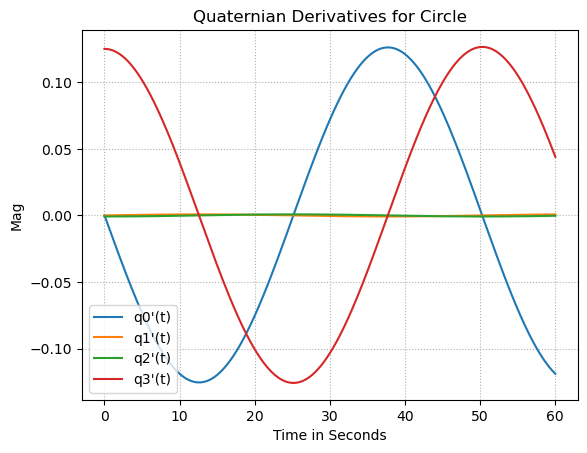

In [24]:
plt.plot(T, q0d_t, label='q0\'(t)')
plt.plot(T, q1d_t, label='q1\'(t)')
plt.plot(T, q2d_t, label='q2\'(t)')
plt.plot(T, q3d_t, label='q3\'(t)')

plt.xlabel('Time in Seconds')
plt.ylabel('Mag')
plt.title('Quaternian Derivatives for Circle')
plt.grid(True, linestyle =':')

plt.legend()

plt.show()

In [24]:
plt.plot(T, phi_t, label='phi(t)')
plt.plot(T, theta_t, label='theta(t)')
plt.plot(T, psi_t, label='psi(t)')

plt.xlabel('Time in Seconds')
plt.ylabel('Angle in Radians')
plt.title('Euler Angles for Circle')
plt.grid(True, linestyle =':')

plt.legend()

plt.show()

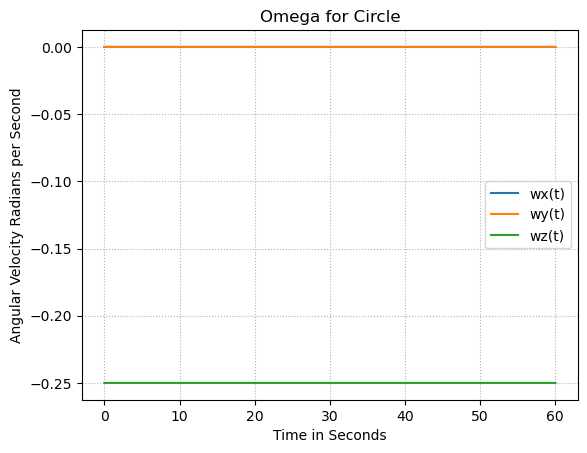

In [35]:
plt.plot(T, wx_t, label='wx(t)')
plt.plot(T, wy_t, label='wy(t)')
plt.plot(T, wz_t, label='wz(t)')

plt.xlabel('Time in Seconds')
plt.ylabel('Angular Velocity Radians per Second')
plt.title('Omega for Circle')
plt.grid(True, linestyle =':')

plt.legend()

plt.show()

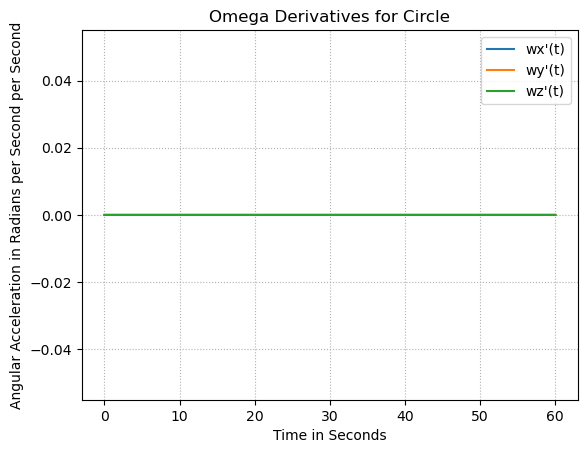

In [36]:
plt.plot(T, wxd_t, label='wx\'(t)')
plt.plot(T, wyd_t, label='wy\'(t)')
plt.plot(T, wzd_t, label='wz\'(t)')

plt.xlabel('Time in Seconds')
plt.ylabel('Angular Acceleration in Radians per Second per Second')
plt.title('Omega Derivatives for Circle')
plt.grid(True, linestyle =':')

plt.legend()

plt.show()

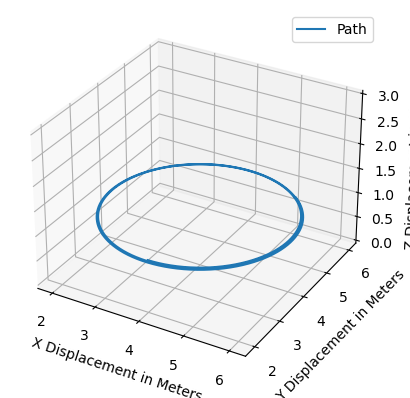

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_t, y_t, z_t, label='Path')
ax.set_zlim(0,3)
ax.set_xlabel('X Displacement in Meters')
ax.set_ylabel('Y Displacement in Meters')
ax.set_zlabel('Z Displacement in Meters')

ax.legend()

plt.show()




In [25]:
%matplotlib qt
trail = false

def update(frame):
    ax.clear()
    
    ax.scatter(x_t[frame], y_t[frame], z_t[frame], c='r', marker='o')
    
    rotation = R_sci.from_euler('xyz', [phi_t[frame], theta_t[frame], psi_t[frame]]).as_matrix()
    
    origin = [x_t[frame], y_t[frame], z_t[frame]]
    scale = 0.5  

    ax.quiver(origin[0], origin[1], origin[2], 
              rotation[0, 0] * scale, rotation[1, 0] * scale, rotation[2, 0] * scale, 
              color='r', label='Phi')
    
    ax.quiver(origin[0], origin[1], origin[2], 
              rotation[0, 1] * scale, rotation[1, 1] * scale, rotation[2, 1] * scale, 
              color='g', label='Theta')
    
    ax.quiver(origin[0], origin[1], origin[2], 
              rotation[0, 2] * scale, rotation[1, 2] * scale, rotation[2, 2] * scale, 
              color='b', label='Psi')
    
    if trail == true:
        ax.plot(x_t, y_t, z_t, label=('Positon at time:', (frame*dt)))

    ax.set_xlim(-3, 7)
    ax.set_ylim(-3, 7)
    ax.set_zlim(-3, 7)
    ax.set_xlabel(('X(',(frame*dt),')'))
    ax.set_ylabel(('Y(',(frame*dt),')'))
    ax.set_zlabel(('Z(',(frame*dt),')'))
    

    ax.legend()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



animation = FuncAnimation(fig, update, frames=len(x_t), interval=dt)

plt.show()

In [26]:
animation.save('animationCircle.gif')
print("done")

MovieWriter ffmpeg unavailable; using Pillow instead.


done
